## Assignment 1 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
##### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

In [60]:
#importing required libraries
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [61]:
#importing the data labels (main+extra)
labels_main = pd.read_csv('Image_classification_data\data_labels_mainData.csv')
labels_extra = pd.read_csv('Image_classification_data\data_labels_extraData.csv')
print("labels_main columns:\n", labels_main.head())
print("\nlabels_extra columns:\n", labels_extra.head())

labels_main columns:
    InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

labels_extra columns:
    InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


In [62]:
#navigating to folder containing colon cell histopathology images
image_folder = 'Image_classification_data\patch_images'
images = os.listdir(image_folder)
print(f"Total Numer of Images: {len(images)}")

Total Numer of Images: 20280


In [63]:
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Images in labels_main but missing from patch_images folder:", csv_images_set - images_set)
print("Images in patch_images folder but missing from labels_main:", images_set - csv_images_set)
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: set()
Images in patch_images folder but missing from labels_main: {'18063.png', '20030.png', '15044.png', '10946.png', '21982.png', '15027.png', '15375.png', '7013.png', '20885.png', '5159.png', '5260.png', '15219.png', '2105.png', '1800.png', '19416.png', '15256.png', '19518.png', '10981.png', '9640.png', '14802.png', '14933.png', '6558.png', '2490.png', '15947.png', '10822.png', '12553.png', '10490.png', '12871.png', '7474.png', '5285.png', '7065.png', '7663.png', '2345.png', '1998.png', '15391.png', '2756.png', '17874.png', '10389.png', '19979.png', '9743.png', '2682.png', '11589.png', '16014.png', '12541.png', '17630.png', '15276.png', '14921.png', '11138.png', '10990.png', '9521.png', '22234.png', '12821.png', '14689.png', '16096.png', '2672.png', '19983.png', '5856.png', '13052.png', '9684.png', '12359.png', '10933.png', '7206.png', '10848.png', '5722.png', '11501.png', '6988.png', '16248.png', '2891.png', '14322.png', '

In [64]:
#defining function to load images
def load_images(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images
#loading the images
image_objects = load_images(image_folder, labels_main['ImageName'])
#adding a new column 'Image' to labels_main
labels_main['Image'] = labels_main['ImageName'].map(image_objects)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image
0,22405,1,22405.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,22406,1,22406.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,22407,1,22407.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,22408,1,22408.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,22409,1,22409.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


In [65]:
#grouping by 'cellTypeName' and 'isCancerous', then counting the entries
cell_type_counts = labels_main.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)
#renamining the columns for clarity
cell_type_counts.columns = ['Non-Cancerous', 'Cancerous']
cell_type_counts

,Non-Cancerous,Cancerous
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


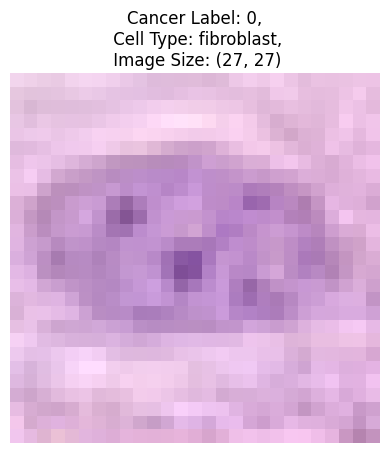

In [66]:
#fetching a single sample (e.g., for index 0)
index = 0
sample = labels_main.iloc[index]
#extracting the image, cancer label, and cell type
img = sample['Image']  # This must be a PIL Image object
cancer_label = sample['isCancerous']
cell_type = sample['cellTypeName']
#displaying the image
if img:
    plt.imshow(img)
    plt.title(f"Cancer Label: {cancer_label},\n Cell Type: {cell_type},\n Image Size: {img.size}")
    plt.axis('off')  #hiding axes
    plt.show()
else:
    print("Error: Image not found.")

### Exploratory Data Analysis (EDA)

In [67]:
#fetching the dimensions of the data
print("Dimensions of labels_main dataframe:", labels_main.shape)
print("\nDescriptive Statistics of labels_main dataframe:")
labels_main.describe()

Dimensions of labels_main dataframe: (9896, 7)

Descriptive Statistics of labels_main dataframe:


,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


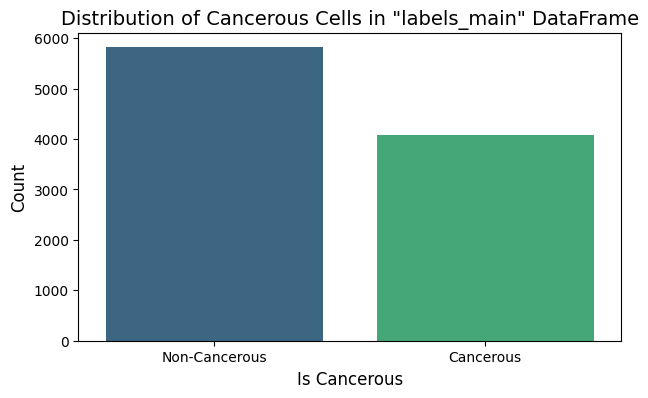

In [68]:
# Plotting the distribution of the 'inCancerous' label
plt.figure(figsize=(7, 4))
sns.countplot(data=labels_main, x='isCancerous', hue="isCancerous", palette='viridis', legend=False)
# Adding titles and labels
plt.title('Distribution of Cancerous Cells in "labels_main" DataFrame', fontsize=14)
plt.xlabel('Is Cancerous', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])  # Adjust according to your label values
# Show the plot
plt.show()

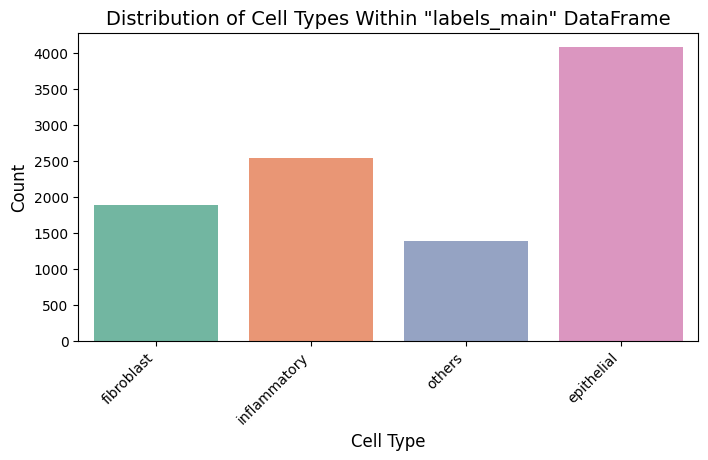

In [69]:
#plotting the distribution of the 'cellTypeName' label
plt.figure(figsize=(8, 4))
sns.countplot(data=labels_main, x='cellTypeName', hue='cellTypeName', palette='Set2', legend=False)
#adding titles and labels
plt.title('Distribution of Cell Types Within "labels_main" DataFrame', fontsize=14)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [70]:
#checking for missing values in the entire DataFrame
missing_values = labels_main.isnull().sum()
#displaying the columns with missing values
print("Missing values in each column:")
print(missing_values)
#optionally, you can filter columns with missing values only
missing_columns = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(missing_columns)

Missing values in each column:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
Image           0
dtype: int64

Columns with missing values:
Series([], dtype: int64)


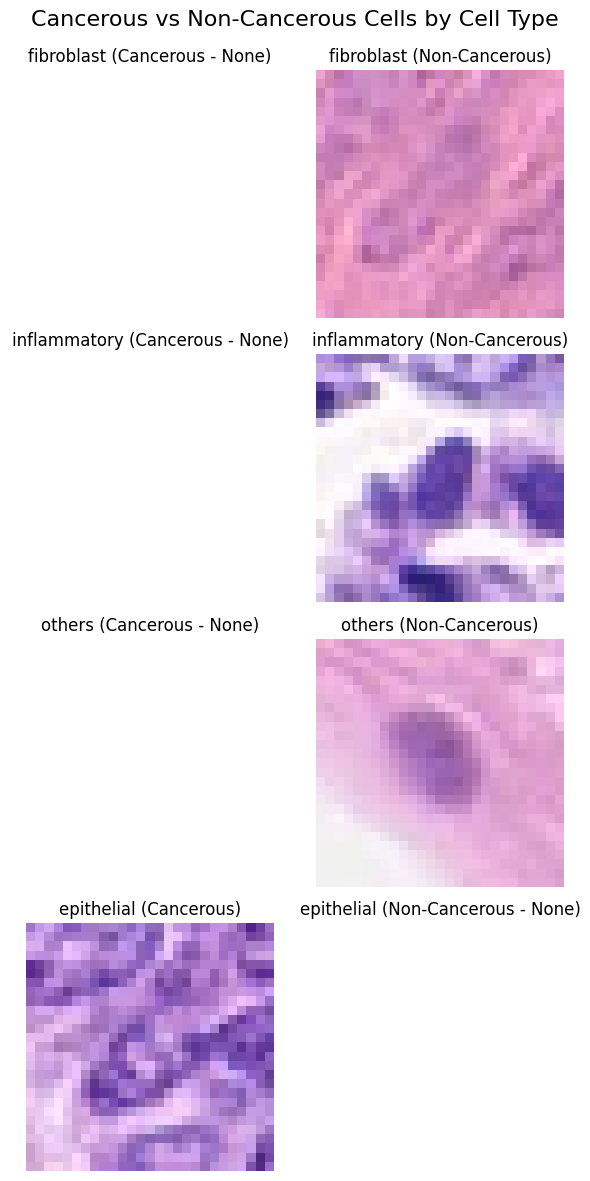

In [71]:
#getting unique cell types
cell_types = labels_main['cellTypeName'].dropna().unique()
#preparing the figure
fig, axes = plt.subplots(len(cell_types), 2, figsize=(6, 3 * len(cell_types)))
#ensure axes is 2D
if len(cell_types) == 1:
    axes = np.expand_dims(axes, axis=0)
#filtering cancerous and non-cancerous data 
for i, cell_type in enumerate(cell_types):
    cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                               (labels_main['isCancerous'] == 1)]
    non_cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                                   (labels_main['isCancerous'] == 0)]
    #plotting cancerous image for cell type
    if not cancerous_df.empty:
        img = cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{cell_type} (Cancerous)")
    else:
        axes[i, 0].set_title(f"{cell_type} (Cancerous - None)")
    axes[i, 0].axis('off')
    #plotting non-cancerous image for cell type
    if not non_cancerous_df.empty:
        img = non_cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous)")
    else:
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous - None)")
    axes[i, 1].axis('off')
#plotting comparison images
plt.suptitle('Cancerous vs Non-Cancerous Cells by Cell Type', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

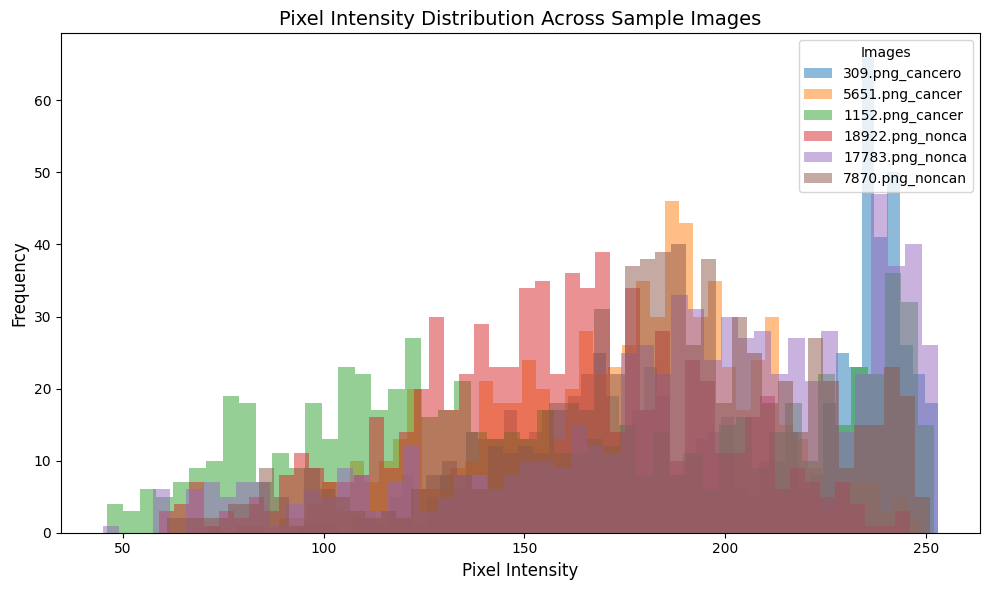

In [72]:
#filtering the main dataframe
cancerous_cells = labels_main[labels_main['isCancerous'] == 1]
non_cancerous_cells = labels_main[labels_main['isCancerous'] == 0]
#defining function to calculate pixel intensity distribution for grayscale images
def plot_pixel_intensity_distribution(images, title="Pixel Intensity Distribution"):
    plt.figure(figsize=(10, 6))
    for idx, (img_name, img) in enumerate(images.items()):
        if img is not None:
            img_gray = img.convert("L")  # Convert image to grayscale
            img_array = np.array(img_gray)
            plt.hist(img_array.flatten(), bins=50, alpha=0.5, label=img_name[:15])  # Truncate long names
    plt.title(title, fontsize=14)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(title="Images", loc='upper right')
    plt.tight_layout()
    plt.show()
#using a sample of 3 cancerous and 3 non-cancerous images
sample_cancerous_images = cancerous_cells.sample(3, random_state=42)
sample_non_cancerous_images = non_cancerous_cells.sample(3, random_state=42)
#combining the images in a dictionary
sample_images = {}
for idx, row in sample_cancerous_images.iterrows():
    sample_images[f"{row['ImageName']}_cancerous"] = row['Image']
for idx, row in sample_non_cancerous_images.iterrows():
    sample_images[f"{row['ImageName']}_noncancerous"] = row['Image']
#plotting the pixel intensity distribution of the 9 images
plot_pixel_intensity_distribution(sample_images, title="Pixel Intensity Distribution Across Sample Images")

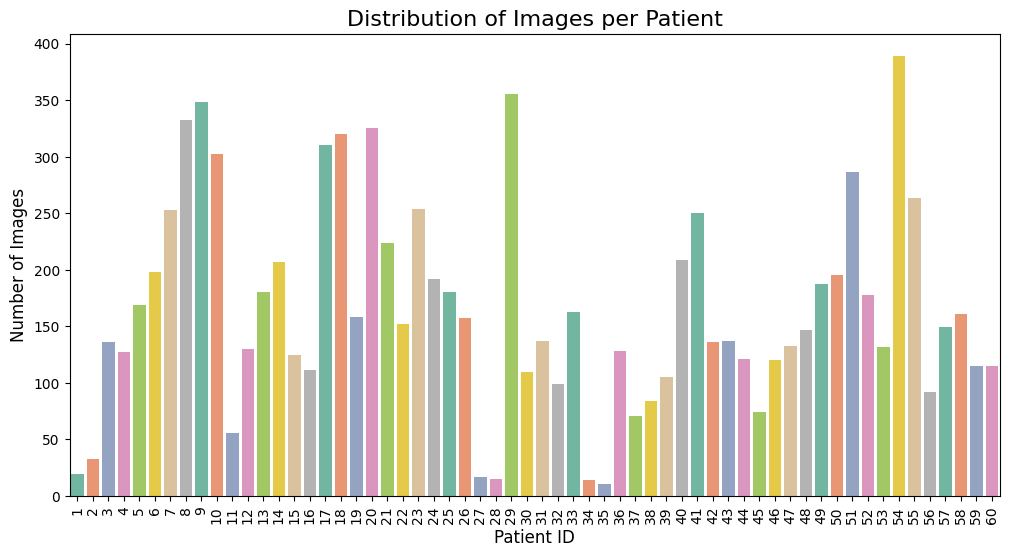

In [73]:
#grouping the data by PatientID and counting the number of images per patient
patient_distribution = labels_main['patientID'].value_counts()
#plotting the patient distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=patient_distribution.index, hue=patient_distribution.index, y=patient_distribution.values, palette="Set2", legend=False)
#adding title and labels
plt.title('Distribution of Images per Patient', fontsize=16)
plt.xlabel('Patient ID', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

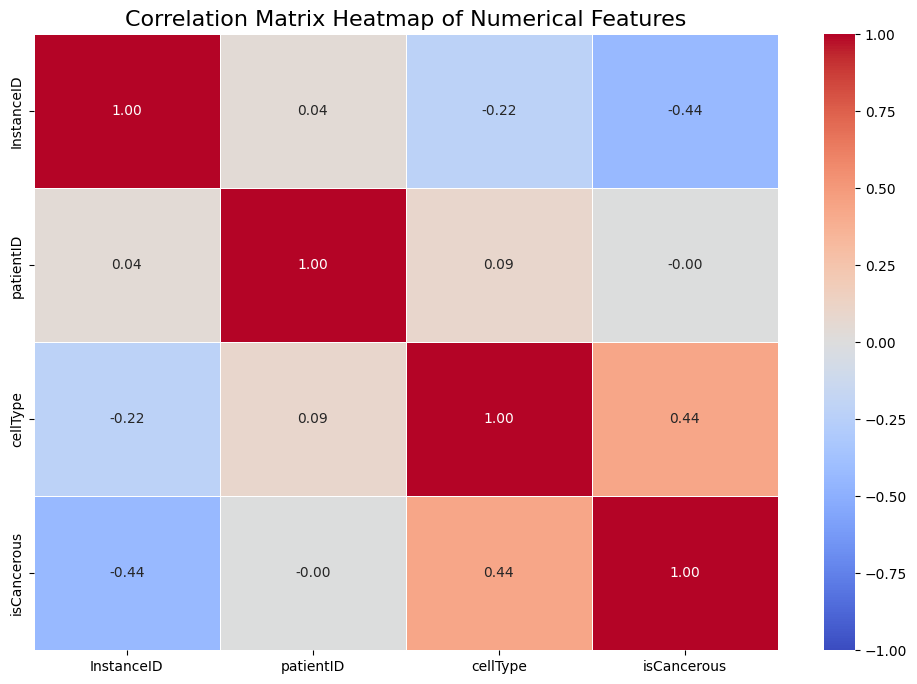

In [74]:
#select only numerical columns
numerical_features = labels_main.select_dtypes(include=['float64', 'int64'])
#calculate the correlation matrix
corr_matrix = numerical_features.corr()
#plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap of Numerical Features', fontsize=16)
plt.show()

In [75]:
#function to classify images as too bright or too dark based on average pixel intensity
def check_image_brightness(images, bright_threshold=200, dark_threshold=50):
    too_bright = []
    too_dark = []  
    for img_name, img in images.items():
        # Convert the image to grayscale
        img_gray = img.convert("L")
        img_array = np.array(img_gray)  # Convert image to numpy array
        #calculate the average pixel intensity
        avg_intensity = img_array.mean()
        #classify image as too bright or too dark
        if avg_intensity > bright_threshold:
            too_bright.append(img_name)
        elif avg_intensity < dark_threshold:
            too_dark.append(img_name)
    return too_bright, too_dark
#check the brightness of the images
too_bright_images, too_dark_images = check_image_brightness(image_objects)
#display the results
print("Too Bright Images:", too_bright_images)
print("Too Dark Images:", too_dark_images)

Too Bright Images: ['22408.png', '22409.png', '22423.png', '19036.png', '19043.png', '19045.png', '19049.png', '19050.png', '19062.png', '19066.png', '18945.png', '18653.png', '132.png', '133.png', '135.png', '153.png', '156.png', '158.png', '161.png', '162.png', '163.png', '164.png', '165.png', '167.png', '168.png', '172.png', '173.png', '175.png', '176.png', '177.png', '178.png', '179.png', '180.png', '181.png', '183.png', '184.png', '187.png', '190.png', '191.png', '192.png', '193.png', '194.png', '195.png', '196.png', '197.png', '198.png', '199.png', '200.png', '201.png', '203.png', '204.png', '205.png', '207.png', '212.png', '213.png', '215.png', '220.png', '221.png', '222.png', '223.png', '227.png', '228.png', '229.png', '230.png', '232.png', '233.png', '234.png', '235.png', '241.png', '242.png', '243.png', '253.png', '254.png', '256.png', '257.png', '260.png', '262.png', '264.png', '270.png', '271.png', '273.png', '274.png', '275.png', '4087.png', '4089.png', '4092.png', '4096.p

### Data Pre-processing

In [76]:

"""    
The following code loads the images, resizes them to 27x27 pixels, normalizes the pixel values, and prepares the labels for CNN training.
The code also combines the labels from the main and extra detasets, however if you do not want to use the extra dataset, you can comment out the lines that load and concate the extra dataset.
The code also handles exceptions while loading images and prints the final shapes of the image dataset and labels.

"""




import numpy as np
from PIL import Image

#list of arrays

X = []
y_isCancerous = []
y_cellType = []

#Combine labels

labels_combined = pd.concat([labels_main,labels_extra], ignore_index=True)

# Build a dictionary for fast lookup
labels_dict = labels_combined.set_index('ImageName').to_dict('index')

# Load and preprocess images
for img_name in images_filtered:

    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img = img.resize((27, 27))  # Make sure it's 27x27
        img_array = np.array(img)
        
        # Normalize pixel values (0–1)
        img_array = img_array / 255.0

        X.append(img_array)
        
        # Fetch labels
        label_info = labels_dict[img_name]
        y_isCancerous.append(label_info['isCancerous'])
        y_cellType.append(label_info['cellType'])  # This will be used later

    except Exception as e:
        print(f"Error processing {img_name}:{e}")

X = np.array(X)
y_isCancerous = np.array(y_isCancerous)
y_cellType = np.array(y_cellType)

print(f"Final image dataset shape: {X.shape}")
print(f"Labels shape (isCancerous): {y_isCancerous.shape}")
print(f"Labels shape (cellType): {y_cellType.shape}")

Final image dataset shape: (9896, 27, 27, 3)
Labels shape (isCancerous): (9896,)
Labels shape (cellType): (9896,)


In [77]:
# Encoding the labels for cell types
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


# Encode cellType labels into integers
le = LabelEncoder()
y_cellType_encoded = le.fit_transform(y_cellType)

# One-hot encode for CNN multi-class classification
y_cellType_encoded = to_categorical(y_cellType_encoded)

print(f"Cell type classes: {le.classes_}")


Num GPUs Available: 0
Cell type classes: [0. 1. 2. 3.]


In [78]:
#Train-Vlidation-Test Split

from sklearn.model_selection import train_test_split

# Split for Task 1 (isCancerous)
X_train_task1, X_test_task1, y_train_task1, y_test_task1 = train_test_split(X, y_isCancerous, test_size=0.2, random_state=42)

# Split for Task 2 (cellType)
X_train_task2, X_test_task2, y_train_task2, y_test_task2 = train_test_split(X, y_cellType_encoded, test_size=0.2, random_state=42)

print(f"Task 1 Train set size: {X_train_task1.shape}")
print(f"Task 2 Train set size: {X_train_task2.shape}")


Task 1 Train set size: (7916, 27, 27, 3)
Task 2 Train set size: (7916, 27, 27, 3)


### Building Baseline Models

#### Baseline Model 1: CNN

In [79]:
# Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN model
cnn_task1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 1 neuron for binary output
])

# Compile the model
cnn_task1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Model summary
cnn_task1.summary()




c:\Users\liyab\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,121 (1.64 MB)

 Trainable params: 429,121 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
#Train the Model
# Training
history_task1 = cnn_task1.fit(X_train_task1, y_train_task1,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2)  # 20% of train set used for validation



Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6285 - loss: 0.6317 - val_accuracy: 0.8150 - val_loss: 0.4023
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8585 - loss: 0.3324 - val_accuracy: 0.8693 - val_loss: 0.3111
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8625 - loss: 0.3166 - val_accuracy: 0.8611 - val_loss: 0.3125
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8850 - loss: 0.2775 - val_accuracy: 0.8794 - val_loss: 0.2917
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8928 - loss: 0.2640 - val_accuracy: 0.8807 - val_loss: 0.2852
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8824 - loss: 0.2890 - val_accuracy: 0.8687 - val_loss: 0.3029
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8847 - loss: 0.2802 - val_accuracy: 0.8826 - val_loss: 0.2935
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8923 - loss: 0.2598 - val_accuracy: 

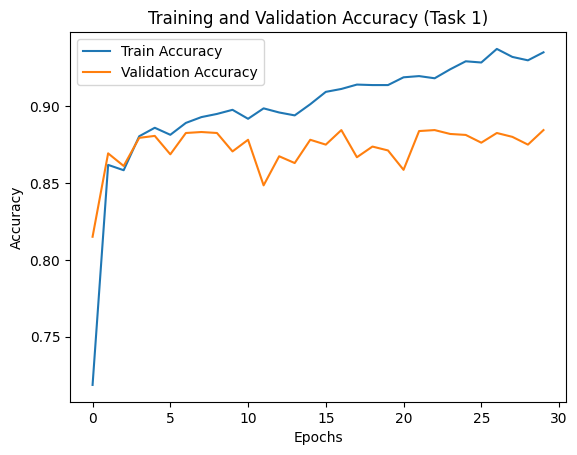

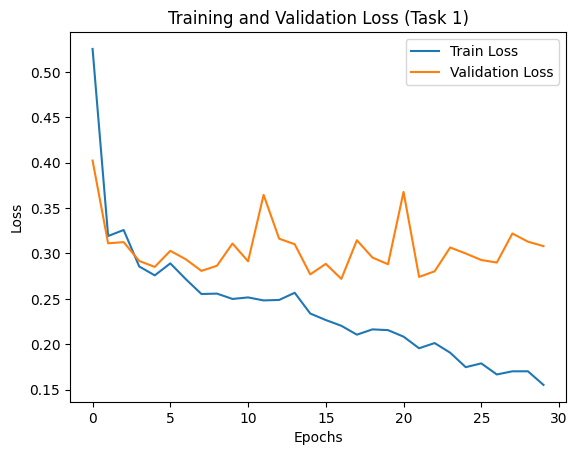

In [81]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history_task1.history['accuracy'], label='Train Accuracy')
plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history_task1.history['loss'], label='Train Loss')
plt.plot(history_task1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [82]:
# Evaluate
test_loss, test_accuracy = cnn_task1.evaluate(X_test_task1, y_test_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8852 - loss: 0.3055
Test Accuracy (Task 1 - isCancerous): 0.8949


In [83]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict
y_pred_task1 = (cnn_task1.predict(X_test_task1) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test_task1, y_pred_task1)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_test_task1, y_pred_task1))


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
 [[1049  137]
 [  71  723]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1186
           1       0.84      0.91      0.87       794

    accuracy                           0.89      1980
   macro avg       0.89      0.90      0.89      1980
weighted avg       0.90      0.89      0.90      1980



#### Baseline Model 2: Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
from PIL import Image
import os


In [45]:
# Function to extract features (flatten the image)
def extract_features(img, size=(27, 27)):
    img_resized = img.convert("L").resize(size)  # Convert to grayscale and resize
    return np.array(img_resized).flatten()  # Flatten to a 1D vector

# Prepare features (flattened images) and labels
X = []
y_cancerous = []
y_celltype = []

for _, row in labels_main.iterrows():
    img = row['Image']  # PIL Image object from 'Image' column
    X.append(extract_features(img))  # Extract features from image
    y_cancerous.append(row["isCancerous"])  # Target: isCancerous
    y_celltype.append(row["cellTypeName"])  # Target: cellTypeName

X = np.array(X)
y_cancerous = np.array(y_cancerous)
y_celltype = np.array(y_celltype)

# Train-Test Split (80% training, 20% test data)
X_train, X_test, y_c_train, y_c_test, y_t_train, y_t_test = train_test_split(
    X, y_cancerous, y_celltype, test_size=0.2, random_state=42, stratify=y_cancerous
)

In [46]:
# Train Random Forest for cancerous classification (isCancerous)
rf_cancerous = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cancerous.fit(X_train, y_c_train)

# Predict on test data
y_c_pred = rf_cancerous.predict(X_test)

# Evaluate the cancerous classification model
print("Cancerous Classification (isCancerous) Results:")
print("Accuracy: ", accuracy_score(y_c_test, y_c_pred))
print("Classification Report:")
print(classification_report(y_c_test, y_c_pred))

# Confusion Matrix for cancerous classification
cm_cancerous = confusion_matrix(y_c_test, y_c_pred)

Cancerous Classification (isCancerous) Results:
Accuracy:  0.7954545454545454
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1164
           1       0.78      0.70      0.74       816

    accuracy                           0.80      1980
   macro avg       0.79      0.78      0.79      1980
weighted avg       0.79      0.80      0.79      1980



In [47]:
# Encode the cell type labels to numeric values
le = LabelEncoder()
y_t_train_encoded = le.fit_transform(y_t_train)
y_t_test_encoded = le.transform(y_t_test)

# Train Random Forest for cell-type classification
rf_celltype = RandomForestClassifier(n_estimators=100, random_state=42)
rf_celltype.fit(X_train, y_t_train_encoded)

# Predict on test data for cell type
y_t_pred = rf_celltype.predict(X_test)

# Evaluate the cell-type classification model
print("\nCell-Type Classification Results:")
print("Accuracy: ", accuracy_score(y_t_test_encoded, y_t_pred))
print("Classification Report:")
print(classification_report(y_t_test_encoded, y_t_pred))

# Confusion Matrix for cell type classification
cm_celltype = confusion_matrix(y_t_test_encoded, y_t_pred)


Cell-Type Classification Results:
Accuracy:  0.6297979797979798
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.89      0.75       816
           1       0.57      0.40      0.47       364
           2       0.61      0.76      0.68       495
           3       0.67      0.01      0.03       305

    accuracy                           0.63      1980
   macro avg       0.62      0.51      0.48      1980
weighted avg       0.63      0.63      0.57      1980



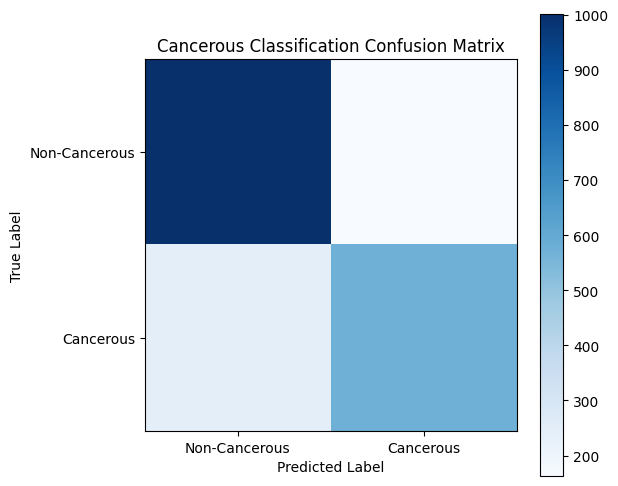

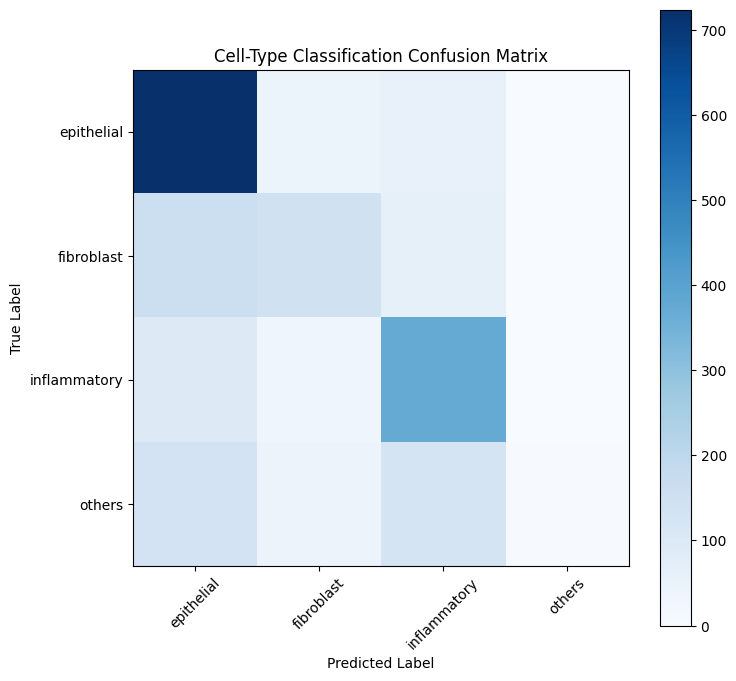

In [48]:
import matplotlib.pyplot as plt

# Plotting Confusion Matrix for cancerous classification
plt.figure(figsize=(6, 6))
plt.imshow(cm_cancerous, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Cancerous Classification Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Cancerous', 'Cancerous'])
plt.yticks(tick_marks, ['Non-Cancerous', 'Cancerous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting Confusion Matrix for cell type classification
plt.figure(figsize=(8, 8))
plt.imshow(cm_celltype, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Cell-Type Classification Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Baseline Model 3: custom CNN with residual blocks

In [51]:
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import numpy as np

In [52]:
# ResNet101 input size
IMG_SIZE = (224, 224)  # ResNet101 typically uses 224x224 images

# Preprocessing the images
def preprocess_images(df, image_column, target_size=IMG_SIZE):
    X = []
    for img in df[image_column]:
        # Resize and convert to numpy array
        img_resized = img.resize(target_size)
        img_array = img_to_array(img_resized)  # Convert to numpy array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize to [0, 1]
        X.append(img_array)
    return np.array(X)

# Preprocess the images
X = preprocess_images(labels_main, 'Image', target_size=IMG_SIZE)

# Split the data into features (X) and labels (y)
y_cancerous = labels_main['isCancerous'].values  # Binary target
y_celltype = labels_main['cellTypeName'].values  # Multi-class target

# Train-Test Split (80% training, 20% test data)
X_train, X_test, y_c_train, y_c_test, y_t_train, y_t_test = train_test_split(
    X, y_cancerous, y_celltype, test_size=0.2, random_state=42, stratify=y_cancerous
)

In [58]:
from tensorflow.keras import layers, models

# Residual block definition with a 1x1 convolution on the shortcut if needed
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    shortcut = x  # Identity mapping

    # First convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)

    # If the number of filters doesn't match, adjust shortcut with 1x1 conv
    if shortcut.shape[-1] != filters or strides != (1, 1):
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection
    x = layers.add([x, shortcut])
    x = layers.Activation("relu")(x)

    return x

# Building ResNet101-like model from scratch using simplified residual blocks
def build_resnet101_model(input_shape=(224, 224, 3)):
    input_layer = layers.Input(shape=input_shape)

    # Initial conv and pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Residual block groups
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=(2, 2))  # downsample
    x = residual_block(x, 128)

    x = residual_block(x, 256, strides=(2, 2))  # downsample
    x = residual_block(x, 256)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = layers.Dense(128, activation="relu")(x)
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# For Cancerous Classification
model_cancerous = build_resnet101_model(input_shape=(224, 224, 3))

# Compile the model
model_cancerous.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model summary
model_cancerous.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ activation_22[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_23[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 56, 56,    │          0 │ add_11[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_24[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_25[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_35[0][0] 

 Total params: 2,822,529 (10.77 MB)

 Trainable params: 2,818,049 (10.75 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [59]:
# Train the model for cancerous classification
history_cancerous = model_cancerous.fit(X_train, y_c_train,
                                        validation_data=(X_test, y_c_test),
                                        epochs=10, batch_size=32)


Epoch 1/10
102/248 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.8034 - loss: 0.4081

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test data
y_c_pred = model_cancerous.predict(X_test)
y_c_pred = (y_c_pred > 0.5).astype(int)  # Threshold predictions to 0 or 1

# Performance metrics for cancerous classification
print("Cancerous Classification Results:")
print("Accuracy: ", accuracy_score(y_c_test, y_c_pred))
print("Classification Report:")
print(classification_report(y_c_test, y_c_pred))

# Confusion Matrix for cancerous classification
cm_cancerous = confusion_matrix(y_c_test, y_c_pred)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode cell type labels
le = LabelEncoder()
y_t_train_encoded = le.fit_transform(y_t_train)
y_t_test_encoded = le.transform(y_t_test)

# Modify the ResNet101 model for multi-class classification
def build_resnet101_celltype_model(input_shape=(224, 224, 3), num_classes=len(le.classes_)):
    model = models.Sequential([
        layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same"),

        # Add residual blocks (same structure)
        layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Add(),
        layers.Activation("relu"),

        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Add(),
        layers.Activation("relu"),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")  # Multi-class classification (Cell-Type)
    ])
    return model

# For Cell-Type Classification
model_celltype = build_resnet101_celltype_model(input_shape=(224, 224, 3), num_classes=len(le.classes_))

# Compile the model
model_celltype.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model summary
model_celltype.summary()

In [ ]:
# Train the model for cell-type classification
history_celltype = model_celltype.fit(X_train, y_t_train_encoded,
                                      validation_data=(X_test, y_t_test_encoded),
                                      epochs=10, batch_size=32)

In [ ]:
# Predict on test data for cell-type classification
y_t_pred = model_celltype.predict(X_test)
y_t_pred = np.argmax(y_t_pred, axis=1)  # Get the class with the highest probability

# Performance metrics for cell-type classification
print("\nCell-Type Classification Results:")
print("Accuracy: ", accuracy_score(y_t_test_encoded, y_t_pred))
print("Classification Report:")
print(classification_report(y_t_test_encoded, y_t_pred))

# Confusion Matrix for cell-type classification
cm_celltype = confusion_matrix(y_t_test_encoded, y_t_pred)

In [ ]:
import matplotlib.pyplot as plt

# Plot Confusion Matrix for cancerous classification
plt.figure(figsize=(6, 6))
plt.imshow(cm_cancerous, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Cancerous Classification Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Cancerous', 'Cancerous'])
plt.yticks(tick_marks, ['Non-Cancerous', 'Cancerous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Confusion Matrix for cell-type classification
plt.figure(figsize=(8, 8))
plt.imshow(cm_celltype, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Cell-Type Classification Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()